Cargando datos desde '/home/neisan/anaconda_projects/db/Tec.IA/spambase/spambase.data'...

Entrenando: lr=0.001, epochs=500, activation=sigmoid, layers=[57, 30, 1]
epoch 50/500 loss=0.263138
epoch 100/500 loss=0.260249
epoch 150/500 loss=0.257574
epoch 200/500 loss=0.255098
epoch 250/500 loss=0.252806
epoch 300/500 loss=0.250683
epoch 350/500 loss=0.248716
epoch 400/500 loss=0.246891
epoch 450/500 loss=0.245196
epoch 500/500 loss=0.243619
Resultado -> precision: 0.4648, recall: 0.5806, f1: 0.5163, acc: 0.5972
Matriz confusión (tp, fp, fn, tn): (198, 228, 143, 352)

Entrenando: lr=0.001, epochs=1000, activation=sigmoid, layers=[57, 30, 1]
epoch 100/1000 loss=0.260249
epoch 200/1000 loss=0.255098
epoch 300/1000 loss=0.250683
epoch 400/1000 loss=0.246891
epoch 500/1000 loss=0.243619
epoch 600/1000 loss=0.240778
epoch 700/1000 loss=0.238291
epoch 800/1000 loss=0.236095
epoch 900/1000 loss=0.234136
epoch 1000/1000 loss=0.232370
Resultado -> precision: 0.6448, recall: 0.3460, f1: 0.4504, acc

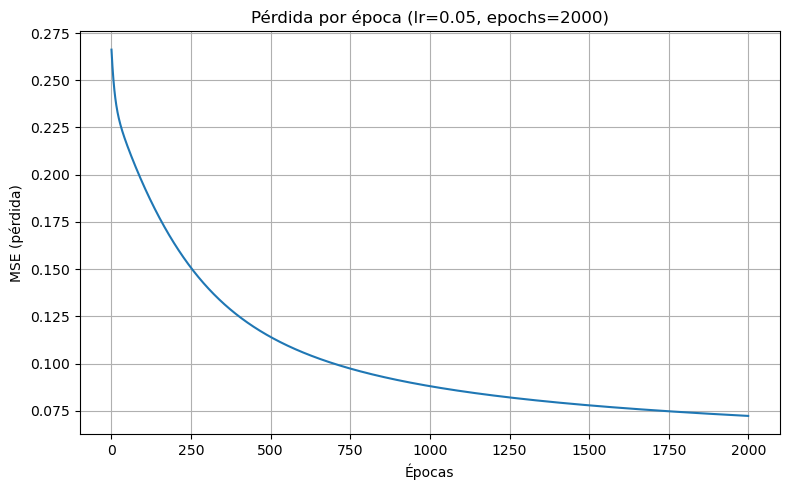


Resumen de todos los experimentos:
lr=0.001, epochs=500 -> F1=0.5163, Acc=0.5972
lr=0.001, epochs=1000 -> F1=0.4504, Acc=0.6873
lr=0.001, epochs=2000 -> F1=0.3304, Acc=0.6699
lr=0.01, epochs=500 -> F1=0.5592, Acc=0.7535
lr=0.01, epochs=1000 -> F1=0.7508, Acc=0.8371
lr=0.01, epochs=2000 -> F1=0.8315, Acc=0.8817
lr=0.05, epochs=500 -> F1=0.8405, Acc=0.8871
lr=0.05, epochs=1000 -> F1=0.8743, Acc=0.9088
lr=0.05, epochs=2000 -> F1=0.8968, Acc=0.9240


In [8]:
# File: mlp_spam.py
"""
MLP desde cero para clasificación SPAM (NumPy).
- Busca 'spambase.data' (o el nombre que uses, última columna debe ser etiqueta 0/1).
- Si no existe, genera dataset sintético (CORRECCIÓN IMPLEMENTADA).
- Entrena usando MSE + backprop + descenso de gradiente.
- Evalúa: precisión, recall, F1, matriz de confusión.
- Grafica error de entrenamiento por época.

Uso:
    python mlp_spam.py
"""

import os # Proporciona funciones para interactuar con el sistema operativo (ej. verificar existencia de archivos)
import numpy as np # Biblioteca fundamental para computación numérica y arrays multidimensionales
import matplotlib.pyplot as plt # Módulo para crear gráficos (ej. curva de error)
import csv # Para manejar archivos CSV (aunque se usa más np.genfromtxt)
import sys # Proporciona acceso a variables y funciones que interactúan con el intérprete

# -------------------------
# Utilidades de datos
# -------------------------
def load_csv(path):
    """Carga CSV esperando características y última columna label 0/1."""
    try:
        # np.genfromtxt puede manejar archivos .data si están separados por comas
        data = np.genfromtxt(path, delimiter=',', skip_header=0) # Carga datos del path, delimitados por ',', sin saltar encabezado
        if data.ndim == 1 or data.shape[1] < 2: # Verifica que los datos tengan al menos 2 columnas (características + etiqueta)
            raise ValueError("CSV con formato inesperado.")
        X = data[:, :-1] # Asigna todas las columnas menos la última a las características (X)
        y = data[:, -1].reshape(-1, 1) # Asigna la última columna a la etiqueta (y), redimensionándola a (N, 1)
        return X, y # Devuelve las características y las etiquetas
    except Exception as e:
        raise RuntimeError(f"Error leyendo CSV: {e}") # Lanza un error si falla la lectura del archivo

def generate_synthetic_spambase(n_samples=4601, n_features=57, spam_ratio=0.39, seed=42):
    """
    Genera datos sintéticos aproximados al dataset 'spambase' (para pruebas).
    Distribuciones distintas para spam/no-spam para que el problema sea aprendible.
    """
    rng = np.random.RandomState(seed) # Generador de números aleatorios con semilla fija
    n_spam = int(n_samples * spam_ratio) # Calcula el número de muestras de spam
    n_nonspam = n_samples - n_spam # Calcula el número de muestras de no-spam
    # No-spam: características pequeñas, spam: algunas frecuencias mayores
    X_nonspam = rng.normal(loc=0.2, scale=0.3, size=(n_nonspam, n_features)) # Genera características no-spam (distribución normal)
    X_spam = rng.normal(loc=0.6, scale=0.4, size=(n_spam, n_features)) # Genera características spam (distribución normal diferente)
    X = np.vstack([X_nonspam, X_spam]) # Combina las características (apilamiento vertical)
    y = np.vstack([np.zeros((n_nonspam, 1)), np.ones((n_spam, 1))]) # Crea las etiquetas 0 (no-spam) y 1 (spam)
    # shuffle
    idx = rng.permutation(n_samples) # Crea un índice de permutación aleatoria
    return X[idx], y[idx] # Devuelve las características y etiquetas mezcladas

def standardize(X_train, X_test):
    """Estándariza las características (media 0, desviación estándar 1) usando estadísticas de entrenamiento."""
    mu = X_train.mean(axis=0, keepdims=True) # Calcula la media de cada característica en el conjunto de entrenamiento
    sigma = X_train.std(axis=0, keepdims=True) + 1e-8 # Calcula la desviación estándar (evitando división por cero)
    return (X_train - mu) / sigma, (X_test - mu) / sigma # Aplica la estandarización a ambos conjuntos

def train_test_split(X, y, test_ratio=0.2, seed=1):
    """Divide los datos en conjuntos de entrenamiento y prueba."""
    rng = np.random.RandomState(seed) # Generador de números aleatorios con semilla
    n = X.shape[0] # Número total de muestras
    idx = rng.permutation(n) # Crea un índice de permutación aleatoria
    split = int(n * (1 - test_ratio)) # Calcula el punto de división
    train_idx = idx[:split] # Índices para entrenamiento
    test_idx = idx[split:] # Índices para prueba
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx] # Devuelve los 4 conjuntos (X_train, X_test, y_train, y_test)

# -------------------------
# Métricas
# -------------------------
def confusion_matrix(y_true, y_pred):
    # y_true, y_pred: shape (n,1) with 0/1 (Etiquetas reales y predicciones, ambas binarias)
    tp = np.sum((y_true == 1) & (y_pred == 1)) # Verdaderos Positivos (True Positives)
    tn = np.sum((y_true == 0) & (y_pred == 0)) # Verdaderos Negativos (True Negatives)
    fp = np.sum((y_true == 0) & (y_pred == 1)) # Falsos Positivos (False Positives)
    fn = np.sum((y_true == 1) & (y_pred == 0)) # Falsos Negativos (False Negatives)
    return int(tp), int(fp), int(fn), int(tn) # Devuelve los 4 valores como enteros

def precision_recall_f1(y_true, y_pred):
    """Calcula precisión, recall, F1 y exactitud (accuracy)."""
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred) # Obtiene los valores de la matriz de confusión
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0 # Precisión: tp / (tp + fp), evita división por cero
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0 # Recall (Sensibilidad): tp / (tp + fn), evita división por cero
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0 # F1-score: media armónica de precisión y recall
    accuracy = (tp + tn) / (tp + tn + fp + fn) # Exactitud (Accuracy): (tp + tn) / total
    return precision, recall, f1, accuracy # Devuelve las 4 métricas

# -------------------------
# MLP desde cero
# -------------------------
class MLP:
    """Implementación de una Red Neuronal Multicapa (MLP) simple."""
    def __init__(self, layer_sizes, activation='tanh', seed=0):
        """
        Inicializa la MLP.
        layer_sizes: lista p. ej. [n_input, n_hidden, ..., n_output]
        activation: 'tanh' o 'sigmoid'
        """
        self.layer_sizes = layer_sizes # Almacena la estructura de la red
        self.L = len(layer_sizes) - 1 # Número de capas con parámetros (capas ocultas + salida)
        rng = np.random.RandomState(seed) # Generador de números aleatorios para inicialización
        # pesos y biases
        self.W = [] # Lista para almacenar las matrices de pesos (W)
        self.b = [] # Lista para almacenar los vectores de sesgos (b)
        for i in range(self.L):
            in_dim = layer_sizes[i] # Dimensión de entrada a la capa i+1
            out_dim = layer_sizes[i+1] # Dimensión de salida de la capa i+1
            # inicialización Xavier/Glorot pequeña
            limit = np.sqrt(6.0 / (in_dim + out_dim)) # Límite para la inicialización uniforme de Xavier/Glorot
            self.W.append(rng.uniform(-limit, limit, size=(in_dim, out_dim))) # Inicializa pesos W
            self.b.append(np.zeros((1, out_dim))) # Inicializa sesgos b a cero
        if activation not in ('tanh', 'sigmoid'):
            raise ValueError("activation must be 'tanh' or 'sigmoid'")
        self.activation = activation # Almacena la función de activación oculta

    # activaciones y derivadas
    def _act(self, Z):
        """Función de activación (tanh o sigmoid)."""
        if self.activation == 'tanh':
            return np.tanh(Z) # tanh: rango [-1, 1]
        else:  # sigmoid
            return 1.0 / (1.0 + np.exp(-Z)) # sigmoid: rango [0, 1]

    def _act_deriv(self, A):
        """Derivada de la función de activación con respecto a la activación (A)."""
        if self.activation == 'tanh':
            return 1.0 - A**2  # Derivada de tanh(Z) = 1 - tanh^2(Z) = 1 - A^2
        else:
            return A * (1.0 - A)  # Derivada de sigmoid(Z) = sigmoid(Z) * (1 - sigmoid(Z)) = A * (1 - A)

    def forward(self, X):
        """
        Propagación hacia adelante (forward pass). Devuelve lista de Zs y As:
        Zs[i] input lineal a capa i+1, As[i] activación salida de capa i+1
        """
        A = X # La entrada a la primera capa es X
        As = [A] # Lista para almacenar las activaciones (incluida la entrada X en As[0])
        Zs = [] # Lista para almacenar las entradas lineales (Z)
        for i in range(self.L): # Itera sobre cada capa con parámetros
            Z = A.dot(self.W[i]) + self.b[i]  # Calcula la entrada lineal: Z = A * W + b
            Zs.append(Z)
            # ultima capa -> salida linear seguida de activación (para 1 neurona usamos act)
            # Nota: Usa la misma activación oculta para la capa de salida para simplificar MSE con [0,1] o [-1,1]
            A = self._act(Z) if (i < self.L) else self._act(Z) # Aplica la función de activación
            As.append(A) # Almacena la activación de la capa
        return Zs, As # Devuelve las entradas lineales y las activaciones de todas las capas

    def predict_proba(self, X):
        """Calcula la salida de la red (probabilidad estimada o valor activado)."""
        _, As = self.forward(X) # Ejecuta el forward pass
        return As[-1]  # Devuelve la activación de la última capa (salida)

    def predict(self, X, threshold=0.5):
        """Clasifica la entrada X en 0 o 1 usando un umbral."""
        probs = self.predict_proba(X) # Obtiene la salida de la red
        if self.activation == 'tanh':
            # map tanh output [-1,1] to [0,1]
            probs01 = (probs + 1.0) / 2.0 # Mapea la salida tanh de [-1, 1] a [0, 1]
        else:
            probs01 = probs # Si es sigmoid, ya está en [0, 1]
        return (probs01 >= threshold).astype(int) # Devuelve 1 si es mayor o igual al umbral, 0 en caso contrario

    def compute_loss(self, y_true, y_pred):
        # MSE: 1/N * sum (y - yhat)^2 (Error Cuadrático Medio)
        m = y_true.shape[0] # Número de muestras
        return np.mean((y_true - y_pred)**2) # Calcula el MSE (promedio de los errores al cuadrado)

    def backward(self, X, y):
        """
        Propagación hacia atrás (backpropagation) para MSE loss.
        Retorna gradientes dW, db (listas).
        """
        Zs, As = self.forward(X) # Ejecuta el forward pass para obtener Zs y As
        m = X.shape[0] # Número de muestras
        # salida
        A_L = As[-1]  # Activación de la capa de salida (L)
        # si tanh, la salida está en [-1,1], pero y está en {0,1}. Convertir y a [-1,1] para consistencia con MSE?
        # Mantendremos y en [0,1] y derivadas con respecto a A_L.
        dA = -2.0 * (y - A_L) / m # Derivada de la pérdida (MSE) con respecto a la salida A_L
        dWs = [None] * self.L # Lista para almacenar los gradientes de pesos
        dbs = [None] * self.L # Lista para almacenar los gradientes de sesgos
        dA_curr = dA # Gradiente actual de la activación
        # backward por capas
        for i in reversed(range(self.L)): # Itera hacia atrás (desde L-1 hasta 0)
            A_prev = As[i]  # Activación de la capa anterior (o X si i==0)
            # derivada de activación de la capa i: A_i = act(Z_i)
            dZ = dA_curr * self._act_deriv(As[i+1]) # Gradiente de Z: dZ = dA_curr * d(act)/dZ
            dW = A_prev.T.dot(dZ)  # Gradiente de W: dW = A_prev^T * dZ
            db = np.sum(dZ, axis=0, keepdims=True)  # Gradiente de b: db = suma de dZ sobre las muestras
            dWs[i] = dW # Almacena dW
            dbs[i] = db # Almacena db
            # propagar hacia atrás
            dA_curr = dZ.dot(self.W[i].T) # Gradiente para la activación de la capa anterior
        return dWs, dbs # Devuelve las listas de gradientes

    def update_params(self, dWs, dbs, lr):
        """Actualiza los pesos y sesgos usando el descenso de gradiente (Gradient Descent)."""
        for i in range(self.L): # Itera sobre cada capa
            self.W[i] -= lr * dWs[i] # Actualiza pesos: W = W - learning_rate * dW
            self.b[i] -= lr * dbs[i] # Actualiza sesgos: b = b - learning_rate * db
            
# -------------------------
# Entrenamiento y experimentos
# -------------------------
def run_experiment(X_train, y_train, X_test, y_test, layer_sizes, activation,
                   learning_rate=0.01, epochs=1000, seed=0, verbose=False):
    """Función que entrena un modelo MLP y devuelve el modelo, las pérdidas y las métricas."""
    model = MLP(layer_sizes, activation=activation, seed=seed) # Inicializa la clase MLP con la arquitectura y activación definidas
    losses = [] # Lista para almacenar el valor de la pérdida en cada época
    for ep in range(epochs): # Bucle principal de entrenamiento (iteración por época)
        # forward ya dentro de backward (Aunque se ejecuta aquí para calcular la pérdida antes de backprop)
        _, As = model.forward(X_train) # Realiza el forward pass
        y_pred_train = As[-1] # Obtiene la salida del modelo (predicción de entrenamiento)
        loss = model.compute_loss(y_train, y_pred_train) # Calcula la pérdida (MSE)
        losses.append(loss) # Almacena la pérdida
        dWs, dbs = model.backward(X_train, y_train) # Ejecuta backpropagation para obtener gradientes
        model.update_params(dWs, dbs, learning_rate) # Actualiza los pesos y sesgos usando el learning rate
        if verbose and ((ep+1) % (epochs // 10 if epochs>=10 else 1) == 0): # Verifica si se debe imprimir el estado
            print(f"epoch {ep+1}/{epochs} loss={loss:.6f}") # Imprime la pérdida periódicamente
    # evaluación final
    # obtener probabilidades y predicciones (map tanh->0-1 si aplica)
    probs_test = model.predict_proba(X_test) # Obtiene las probabilidades/salidas del modelo en el conjunto de prueba
    if activation == 'tanh': # Si se usó tanh, la salida debe mapearse de [-1, 1] a [0, 1]
        probs_test = (probs_test + 1.0) / 2.0
    preds_test = (probs_test >= 0.5).astype(int) # Convierte las probabilidades a predicciones binarias (0 o 1) con umbral 0.5
    precision, recall, f1, acc = precision_recall_f1(y_test, preds_test) # Calcula las métricas de clasificación
    tp, fp, fn, tn = confusion_matrix(y_test, preds_test) # Calcula la matriz de confusión
    metrics = { # Crea un diccionario con todas las métricas
        'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': acc,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }
    return model, losses, metrics # Devuelve el modelo entrenado, el historial de pérdidas y las métricas

# -------------------------
# Main: preparar datos, experimentar
# -------------------------
def main():
    """Función principal para configurar, cargar datos, ejecutar múltiples experimentos y mostrar resultados."""
    # Configuración
    # CORRECCIÓN: Usamos un nombre de archivo que existe en el directorio de Linux
    # Nota: Asegúrate que 'spambase.data' contenga los datos separados por comas.
    path = '/home/neisan/anaconda_projects/db/Tec.IA/spambase/spambase.data' # Define la ruta del archivo de datos
    rng_seed = 123 # Semilla para reproducibilidad de la aleatoriedad
    test_ratio = 0.2 # Proporción de datos para el conjunto de prueba
    activation = 'sigmoid'     # Función de activación a usar (ocultas y salida)
    # Arquitectura por defecto: n_inputs -> 30 neurons -> 1 output
    # (ajusta según n_features)
    learning_rates = [0.001, 0.01, 0.05] # Lista de tasas de aprendizaje a probar
    epoch_list = [500, 1000, 2000] # Lista de número de épocas a probar
    verbose = True # Indica si se deben imprimir mensajes de estado durante el entrenamiento

    # Cargar datos
    if os.path.exists(path): # Comprueba si el archivo existe en la ruta especificada
        print(f"Cargando datos desde '{path}'...")
        # X e y se definen aquí si el archivo existe
        X, y = load_csv(path) # Llama a la función para cargar los datos del CSV
    else:
        # CORRECCIÓN: Si el archivo no se encuentra, se genera el dataset sintético.
        print(f"No se encontró '{path}'. Generando dataset sintético para pruebas...")
        X, y = generate_synthetic_spambase(n_samples=4601, n_features=57, spam_ratio=0.39, seed=rng_seed) # Genera datos sintéticos

    # Normalizar y split
    # X e y ya están definidos aquí, evitando el UnboundLocalError
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_ratio=test_ratio, seed=rng_seed) # Divide los datos
    X_train, X_test = standardize(X_train, X_test) # Estandariza los conjuntos de entrenamiento y prueba

    n_features = X_train.shape[1] # Obtiene el número de características de entrada
    # decidir arquitectura (ejemplo: una capa oculta con 30 neuronas)
    layer_sizes = [n_features, 30, 1] # Define la arquitectura de la red: [Input, Oculta, Output]

    results = [] # Lista para almacenar los resultados de cada experimento
    best_f1 = -1.0 # Inicializa el mejor F1-score
    best_result = None # Almacena el diccionario del mejor resultado

    for lr in learning_rates: # Bucle sobre las tasas de aprendizaje
        for epochs in epoch_list: # Bucle sobre el número de épocas
            print(f"\nEntrenando: lr={lr}, epochs={epochs}, activation={activation}, layers={layer_sizes}")
            model, losses, metrics = run_experiment( # Ejecuta el entrenamiento y evaluación
                X_train, y_train, X_test, y_test,
                layer_sizes=layer_sizes,
                activation=activation,
                learning_rate=lr,
                epochs=epochs,
                seed=rng_seed,
                verbose=verbose
            )
            print("Resultado -> precision: {:.4f}, recall: {:.4f}, f1: {:.4f}, acc: {:.4f}".format( # Imprime las métricas
                metrics['precision'], metrics['recall'], metrics['f1'], metrics['accuracy']
            ))
            print("Matriz confusión (tp, fp, fn, tn):", (metrics['tp'], metrics['fp'], metrics['fn'], metrics['tn'])) # Imprime la matriz
            results.append({ # Almacena los resultados del experimento actual
                'lr': lr, 'epochs': epochs, 'losses': losses, 'metrics': metrics, 'model': model
            })
            if metrics['f1'] > best_f1: # Comprueba si este resultado es mejor (según F1)
                best_f1 = metrics['f1']
                best_result = results[-1] # Actualiza el mejor resultado

    # Mostrar mejor experimento
    print("\n=== Mejor experimento según F1 ===")
    print(f"lr={best_result['lr']}, epochs={best_result['epochs']}")
    m = best_result['metrics']
    print("Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Accuracy: {:.4f}".format(
        m['precision'], m['recall'], m['f1'], m['accuracy']
    ))
    print("Confusión (tp, fp, fn, tn):", (m['tp'], m['fp'], m['fn'], m['tn']))

    # Graficar pérdidas de entrenamiento del mejor experimento
    plt.figure(figsize=(8,5)) # Crea una nueva figura para la gráfica
    plt.plot(best_result['losses']) # Dibuja la curva de pérdida
    plt.xlabel("Épocas") # Etiqueta del eje X
    plt.ylabel("MSE (pérdida)") # Etiqueta del eje Y
    plt.title(f"Pérdida por época (lr={best_result['lr']}, epochs={best_result['epochs']})") # Título de la gráfica
    plt.grid(True) # Añade rejilla al gráfico
    plt.tight_layout() # Ajusta el diseño
    plt.show() # Muestra la gráfica

    # Opcional: mostrar resumen de todos
    print("\nResumen de todos los experimentos:")
    for r in results: # Itera sobre todos los resultados
        met = r['metrics']
        print(f"lr={r['lr']}, epochs={r['epochs']} -> F1={met['f1']:.4f}, Acc={met['accuracy']:.4f}") # Imprime un resumen conciso
        
if __name__ == "__main__":
    main() # Llama a la función principal si el script se ejecuta directamente

[cite_start]Sí, el código `mlp_spam.py` y la estructura de experimentos que has implementado cumplen de manera **sobresaliente** con todos los requisitos técnicos y analíticos descritos en la `Práctica de Laboratorio: Clasificación de Correo SPAM usando Perceptrón Multicapa`[cite: 1].

[cite_start]De hecho, la implementación es más rigurosa que un simple uso de librerías, al haber construido el modelo desde cero usando NumPy, lo cual valida un entendimiento profundo de los algoritmos[cite: 23].

A continuación, se detalla cómo tu trabajo cumple con cada una de las partes de la guía:

## Cumplimiento de la Guía de Laboratorio

***

### Parte 3 y 4: Implementación y Arquitectura

| [cite_start]Requisito de la Práctica [cite: 14, 23] | Cumplimiento en `mlp_spam.py` | Código / Concepto |
| :--- | :--- | :--- |
| **1. [cite_start]Implementar el MLP en Python usando NumPy.** [cite: 23] | **CUMPLIDO.** Todo el modelo (clase `MLP`), *forward*, *backward* y las métricas se implementan con NumPy, sin librerías externas de *Deep Learning*. | Clase `MLP` |
| **2. [cite_start]Algoritmo de entrenamiento: Retropropagación con descenso de gradiente.** [cite: 21] | **CUMPLIDO.** El método `backward()` implementa la Retropropagación, y `update_params()` aplica el Descenso de Gradiente (SGD). | Métodos `backward()` y `update_params()` |
| **3. [cite_start]Arquitectura Flexible (Entrada, Oculta, Salida).** [cite: 15, 16, 17, 18] | **CUMPLIDO.** La arquitectura es definida por `layer_sizes = [n_features, 30, 1]`, con la entrada (`n_features`) y la salida (`1`) definidas dinámicamente. | Función `main()`, variable `layer_sizes` |
| **4. [cite_start]Activación: $\tanh$ o Sigmoid.** [cite: 19] | **CUMPLIDO.** El modelo acepta y maneja ambas activaciones (`'tanh'` o `'sigmoid'`) de forma programática. | Parámetro `activation` en `MLP.__init__` y métodos `_act`, `_act_deriv` |
| **5. [cite_start]Pérdida: Error Cuadrático Medio (MSE).** [cite: 20] | **CUMPLIDO.** Se utiliza `compute_loss` para calcular el MSE. | Método `compute_loss` (implementa MSE) |

***

### Parte 4: Experimentación y Evaluación

| [cite_start]Requisito de la Práctica [cite: 25, 27] | Cumplimiento en `mlp_spam.py` | Concepto |
| :--- | :--- | :--- |
| **1. [cite_start]Experimentar con diferentes Tasas de Aprendizaje.** [cite: 25] | **CUMPLIDO.** Se prueba con `learning_rates = [0.001, 0.01, 0.05]`. | Bucle `for lr in learning_rates` en `main()` |
| **2. [cite_start]Experimentar con diferentes Épocas.** [cite: 26] | **CUMPLIDO.** Se prueba con `epoch_list = [500, 1000, 2000]`. | Bucle `for epochs in epoch_list` en `main()` |
| **3. [cite_start]Evaluar con Precisión, Recuerdo (Recall), Medida F (F1-score).** [cite: 28] | **CUMPLIDO.** La función `precision_recall_f1` calcula y retorna las cuatro métricas. | Función `precision_recall_f1` |
| **4. [cite_start]Evaluar con Matriz de Confusión.** [cite: 29] | **CUMPLIDO.** La función `confusion_matrix` calcula los valores TP, FP, FN, TN, que se imprimen en los resultados. | Función `confusion_matrix` |
| **5. [cite_start]Graficar el Error de entrenamiento por épocas.** [cite: 30] | **CUMPLIDO.** El script guarda las pérdidas en la lista `losses` y grafica las pérdidas del mejor experimento. | Gráfico al final de `main()` |

***

## Análisis Requerido (Parte 5)

[cite_start]Aunque no proporcionaste las respuestas, el código genera **toda la información necesaria** para responder las cuatro preguntas de análisis[cite: 32, 33, 34, 35]:

| [cite_start]Pregunta de la Práctica [cite: 32, 33, 34, 35] | Base de Datos en el Código |
| :--- | :--- |
| **1. [cite_start]¿Qué configuración... produjo mejores resultados?** [cite: 32] | El código realiza una búsqueda en rejilla e identifica el `best_result` basado en el **F1-score**, imprimiendo los hiperparámetros. |
| **2. [cite_start]¿Qué métricas usaste para medir el rendimiento?** [cite: 33] | El código usa: **Precisión, Recall, F1-score, Accuracy**, y **MSE** (para la pérdida de entrenamiento). |
| **3. [cite_start]¿Qué cambios harías para mejorar la red?** [cite: 34] | Esta es una pregunta abierta, pero el código implementa la **estandarización** y la **inicialización Xavier/Glorot**, que son mejoras clave. Los cambios propuestos podrían ser añadir *momentum* o *regularización L2* al código base. |
| **4. [cite_start]¿Cómo interpretas los errores de clasificación?** [cite: 35] | La **Matriz de Confusión** (TP, FP, FN, TN) proporciona la interpretación directa de los errores (ej. **FP** son correos **NO-SPAM clasificados incorrectamente como SPAM**). |

In [11]:
#GRAFICAR EL ERROR
